# Overview

Welcome to this data analysis notebook where we delve into the exploration of the gender wage gap using the Current Population Survey by the U.S. Census Bureau. Our primary goal is to conduct a comprehensive examination of both the conditional (based on factors such as education and age) and unconditional gender wage gaps.

To achieve this, we leverage the power of two robust visualization tools: Seaborn and Plotnine. Through compelling visualizations, we aim to provide clear insights into the patterns and variations in wage gaps, shedding light on how factors like education and age contribute to these disparities.

In our analysis, we will also use visualization tools to show and explain our findings about the gender wage gap. By the end of this notebook, we aim to provide a clear understanding of the wage gap overall and how it's affected by things like age and job factors.

### The dataset

The cps-earnings dataset is  [here](https://osf.io/g8p9j/) (Crosssection. N=149,316 individuals).

Occupation codes are here: [here](https://osf.io/57n9q/). 



In [1]:
# importing all libraries
import os
import sys
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

# removing warnings

warnings.filterwarnings("ignore")

In [2]:
# importing the data

df = pd.read_csv('https://osf.io/download/4ay9x/')

In [3]:
# checking the number of rows and columns

df.shape

(149316, 23)

In [4]:
# check columns names

df.columns

Index(['Unnamed: 0', 'hhid', 'intmonth', 'stfips', 'weight', 'earnwke',
       'uhours', 'grade92', 'race', 'ethnic', 'age', 'sex', 'marital',
       'ownchild', 'chldpres', 'prcitshp', 'state', 'ind02', 'occ2012',
       'class', 'unionmme', 'unioncov', 'lfsr94'],
      dtype='object')

In [5]:
# want to see all columns
pd.set_option('display.max_columns', None)

In [6]:
# check na values
df.isna().sum()

Unnamed: 0         0
hhid               0
intmonth           0
stfips             0
weight             0
earnwke            0
uhours             0
grade92            0
race               0
ethnic        129245
age                0
sex                0
marital            0
ownchild           0
chldpres           0
prcitshp           0
state              0
ind02              0
occ2012            0
class              0
unionmme           0
unioncov       17096
lfsr94             0
dtype: int64

### Selecting occupations
We are going to use only two occupation types:
Web developers(1) and Office and Administrative Support Occupations(2)

We will start with Web developers

Their code is 1030

In [7]:
# we are setting values 1 for the first sample
df.loc[df["occ2012"] == 1030, "sample"] = 1 #Web developers
# sample == 1

# we are setting values 2 for the second sample
df.loc[((df["occ2012"] >= 5000) & (df["occ2012"] <= 5999)), "sample"] = 2
#Office and Administrative Support Occupations
# sample == 2
df.loc[df["sample"].isna(), "sample"] = 0 # were NAs input zeros

df.shape

(149316, 24)

In [8]:
# checking if sample column is there
df.columns

Index(['Unnamed: 0', 'hhid', 'intmonth', 'stfips', 'weight', 'earnwke',
       'uhours', 'grade92', 'race', 'ethnic', 'age', 'sex', 'marital',
       'ownchild', 'chldpres', 'prcitshp', 'state', 'ind02', 'occ2012',
       'class', 'unionmme', 'unioncov', 'lfsr94', 'sample'],
      dtype='object')

In [9]:
# we are picking the data only from samples
df = df.loc[ (df["sample"] == 1) | (df["sample"] == 2), : ].reset_index(drop=True)
df.shape

(20241, 24)

In [10]:
# to check how many web developers(1) and office specialists we have(2)
df["sample"].value_counts()

sample
2.0    20025
1.0      216
Name: count, dtype: int64

We have 216 web developers and 20025 office specialists

### Analyzing the data

We are going to create 4 variables
- female
- hourly wages
- log of hourly wages (dependent variable)
- age squared

In [11]:
df["female"] = (df["sex"] == 2) # we are creating a new column which has values true if it's female
df["w"] = df["earnwke"] / df["uhours"] # calculating hourly wage
df["lnw"] = np.log(df["w"])  # calculates the natural logarithm of the values in the "w"
df["agesq"] = np.power(df["age"], 2) # calculates the square of the values in the "age"

In [12]:
# we are going to analyze only financial analysts first
data = df.loc[df["sample"] == 1, :].reset_index(drop=True)
data.head(2)


,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,age,sex,marital,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94,sample,female,w,lnw,agesq
0,346,673032906039520,January,AK,411.5571,1346.15,40,39,3,NaN,47,2,7,0,0,"Native, Born In US",94,Executive offices and legislative bodies (9211...,1030,Government - Local,No,No,Employed-At Work,1.0,True,33.65375,3.516124,2209
1,913,138098329500878,January,AR,1786.4459,700.00,40,43,1,NaN,28,2,7,0,0,"Native, Born In US",71,Offices of physicians (6211),1030,Government - State,No,No,Employed-At Work,1.0,True,17.50000,2.862201,784


In [13]:
# checking if additional columns were actually created
df.columns

Index(['Unnamed: 0', 'hhid', 'intmonth', 'stfips', 'weight', 'earnwke',
       'uhours', 'grade92', 'race', 'ethnic', 'age', 'sex', 'marital',
       'ownchild', 'chldpres', 'prcitshp', 'state', 'ind02', 'occ2012',
       'class', 'unionmme', 'unioncov', 'lfsr94', 'sample', 'female', 'w',
       'lnw', 'agesq'],
      dtype='object')

### Visualization of hourly earnings

On x axis is hourly earnings on y axis is their relative frequency

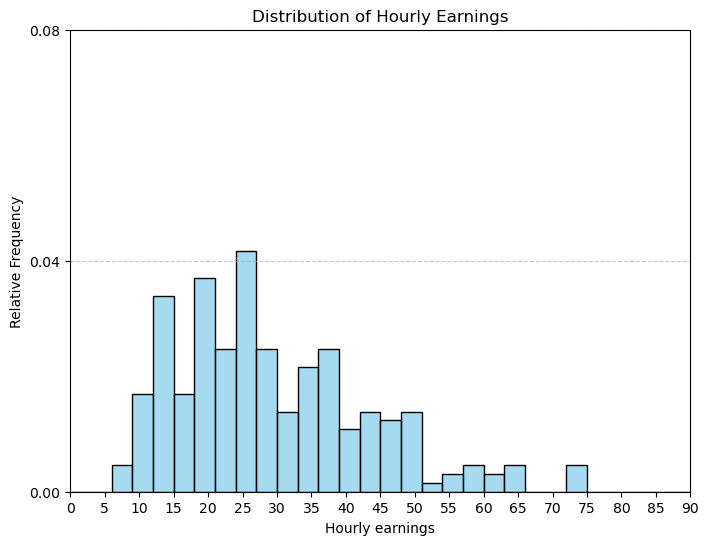

In [14]:
# Set the color palette
sns.set_palette("pastel")

# Create the histogram
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='w', bins=range(0, 91, 3), stat='density', common_norm=False, kde=False, color='skyblue')

# Set labels and title
plt.xlabel('Hourly earnings')
plt.ylabel('Relative Frequency')
plt.title('Distribution of Hourly Earnings')

# Set x-axis and y-axis limits
plt.xlim(0, 90)
plt.ylim(0, 0.08)


# Set ticks and grid
plt.xticks(range(0, 91, 5))
plt.yticks([i/100 for i in range(0, 9, 4)])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


Distribution is skewed positive. It has long right tale and the mean value is bigger than the median.

Using natural logarithm of wage we are getting results closer to the normal distribution.

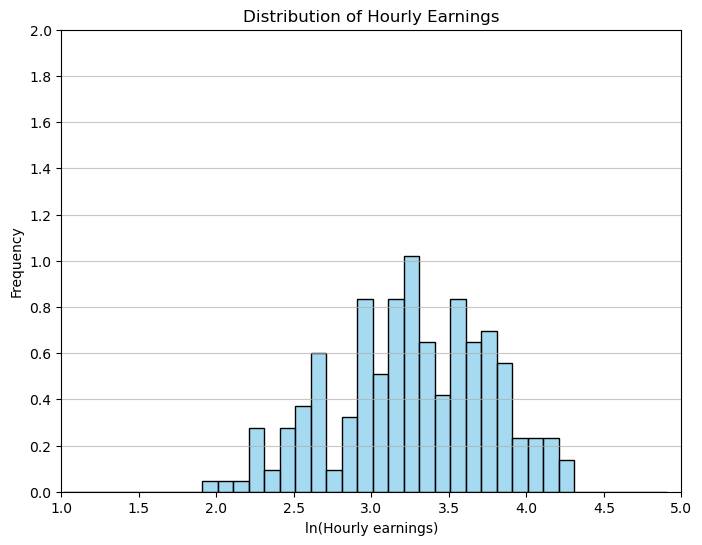

In [15]:

# Set the color palette
sns.set_palette("pastel")

# Create the histogram
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x=data['lnw'], bins=np.arange(1.01, 5.01, 0.1), stat='density', common_norm=False, kde=False, color='skyblue')

# Set labels and title
plt.xlabel('ln(Hourly earnings)')
plt.ylabel('Frequency')
plt.title('Distribution of Hourly Earnings')

# Set x-axis and y-axis limits
plt.xlim(1, 5)
plt.ylim(0, 2)


# Set ticks and grid
plt.xticks(np.arange(1, 5.1, 0.5))
plt.yticks(np.arange(0, 2.1, 0.2))
plt.grid(axis='y', linestyle='-', alpha=0.7)

# Show the plot
plt.show()

In [16]:
data.loc[:, ["earnwke", "uhours", "w", "lnw"]].describe()

,earnwke,uhours,w,lnw
count,216.000000,216.000000,216.000000,216.000000
mean,1189.203241,40.064815,29.281197,3.261399
std,624.433641,8.253285,13.947370,0.493711
min,99.000000,10.000000,6.900000,1.931521
25%,769.230000,40.000000,19.230750,2.956511
50%,1065.380000,40.000000,26.442250,3.274963
75%,1543.267500,40.000000,38.461425,3.649656
max,2884.610000,80.000000,72.115250,4.278266


These statistics provide a snapshot of the central tendency, dispersion, and distribution of your variables, offering valuable insights into the characteristics of your dataset. We can see that normally people work around 40 hours. Also if we look at 75 percentile and max values we can guess that we have large extreme values which can be proved by our visualization above

In [17]:
# number of females
data["female"] = data["female"].astype(int)  #from boolean to 0,1
data["female"].value_counts()

female
0    125
1     91
Name: count, dtype: int64

### Regressions

**Log-level**:

$(\ln{w})^E = \alpha + \beta \times female$

**reg1 (Ordinary Least Squares):**

Standard errors are calculated under the assumption of homoscedasticity, which means that the variance of the errors is constant across all levels of the independent variable(s).
This is the standard method used in ordinary least squares (OLS) regression.

In [18]:
reg1 = smf.ols(formula="lnw~female", data=data).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     7.512
Date:                Fri, 24 Nov 2023   Prob (F-statistic):            0.00665
Time:                        23:51:16   Log-Likelihood:                -149.81
No. Observations:                 216   AIC:                             303.6
Df Residuals:                     214   BIC:                             310.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3388      0.044     76.745      0.000       3.253       3.425
female        -0.1837      0.067     -2.741      0.007      -0.316      -0.052
==============================================================================
Omnibus:                        6.479   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                4.626
Skew:                          -0.226   Prob(JB):                       0.0990
Kurtosis:                       2.443   Cond. No.                         2.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Slope: female web developers earn 18\% ($\beta\times 100\%$) less, on average than male web developers

**reg2 (Heteroskedasticity-Corrected):**

Standard errors are calculated using the Heteroskedasticity-Consistent (HC1) method.
Heteroskedasticity occurs when the variance of the errors is not constant across all levels of the independent variable(s). The HC1 method adjusts for this by providing robust standard errors that are more reliable in the presence of heteroskedasticity.

In [19]:
reg2 = smf.ols(formula="lnw~female", data=data).fit(cov_type="HC1") 
#heteroskedastic-consistent standard errors
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     7.400
Date:                Fri, 24 Nov 2023   Prob (F-statistic):            0.00706
Time:                        23:51:16   Log-Likelihood:                -149.81
No. Observations:                 216   AIC:                             303.6
Df Residuals:                     214   BIC:                             310.4
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3388      0.043     78.352      0.000       3.255       3.422
female        -0.1837      0.068     -2.720      0.007      -0.316      -0.051
==============================================================================
Omnibus:                        6.479   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                4.626
Skew:                          -0.226   Prob(JB):                       0.0990
Kurtosis:                       2.443   Cond. No.                         2.47
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Robust SE slope: 0.068, CI $[-0.316,-0.051]$ (wide)

-> in 2014 in the USA we can be 95\% confident that the average difference between hourly earnings of female market analysts versus male was -31\% to -0.5\%

-> the CI *doesn't include* zero which means that we can **rule out** with 95\% confidence that their average earnings (female and male) are the same 

-> $|t|=2.7>1.96$, therefore we can reject $H_0$

-> it can be seen also by p-value$< 0.05$

-> the coefficient considered statistically significant at 5\%

Based on the analysis, there is statistical evidence to suggest a significant difference in hourly earnings between female and male market analysts in 2014 in the USA.

In [20]:
stargazer = Stargazer([reg1, reg2])
stargazer.covariate_order(["female", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer


The difference between 2 models are very small.

## Gender wage gap considering level of education(using office workers dataset)

In [21]:
# we are going to analyze education level effect on gender gap using data only on office specialists


cps = df.loc[df["sample"] == 2, :].reset_index(drop=True)
cps.head()

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,age,sex,marital,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94,sample,female,w,lnw,agesq
0,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,27,2,1,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent,2.0,True,11.250,2.420368,729
1,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,46,2,1,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work,2.0,True,20.673,3.028829,2116
2,14,199020788270970,January,AL,2852.4443,360.00,40,39,1,NaN,25,2,7,0,0,"Native, Born In US",63,Business support services (5614),5100,"Private, For Profit",No,No,Employed-At Work,2.0,True,9.000,2.197225,625
3,20,420919096203339,January,AL,3862.8767,510.00,40,39,2,NaN,56,1,1,0,0,"Native, Born In US",63,"Water, steam, air-conditioning, and irrigation...",5530,"Private, For Profit",No,No,Employed-At Work,2.0,False,12.750,2.545531,3136
4,27,700109914031181,January,AL,3288.3765,448.00,40,39,2,NaN,39,2,5,1,4,"Native, Born In US",63,Drycleaning and laundry services (8123),5620,"Private, For Profit",No,No,Employed-At Work,2.0,True,11.200,2.415914,1521


In [22]:
# master, professional, phd

cps["ed_MA"] = (cps["grade92"] == 44).astype(int)
cps["ed_Profess"] = (cps["grade92"] == 45).astype(int)
cps["ed_Phd"] = (cps["grade92"] == 46).astype(int)

In [23]:
# adding female, hourly wage and log hourly wages
cps["female"] = (cps.sex == 2).astype(int) #dummy
cps["w"] = cps["earnwke"] / cps["uhours"] #hourly wages
cps["lnw"] = np.log(cps["w"]) #log hourly wages

In [24]:
# creating 3 regresions
reg4 = smf.ols(formula="lnw~female", data=cps).fit(cov_type="HC1") #uncoditional
reg5 = smf.ols(formula="lnw~female + ed_Profess + ed_Phd", data=cps).fit(cov_type="HC1") # conditional
reg6 = smf.ols(formula="lnw~female + ed_Profess + ed_MA", data=cps).fit(cov_type="HC1") # conditional

In [25]:
stargazer = Stargazer([reg4, reg5, reg6])
stargazer.covariate_order([ "female","ed_Profess", "ed_Phd", "ed_MA", "Intercept"])
stargazer

**Interpretation**

(1)In general female office specialists earn 3 percent less than male office specialist. This is our ucnoditional gender gap

(2)
Having a Ph.D. (ed_Phd) is associated with an increase of 39 log point of hourly wages(we could use percents, but it is not very close when the coeficient is more than 0.3). For having a professional degree it's 37 log points.

(3)
Having a MA (ed_Phd) is associated with an increase of 30 percent. For having a professional degree it's 38 log points.


The difference between conditional and uncoditional gender gap is small

# Gender gap considering age

In [26]:
# creating 3 models: women, men and all
reg7 = smf.ols(formula="lnw~age", data=cps.query("female==1")).fit(cov_type="HC1")
reg8 = smf.ols(formula="lnw~age", data=cps.query("female==0")).fit(cov_type="HC1")
reg9 = smf.ols(formula="lnw~female+age+age*female", data=cps).fit(cov_type="HC1")

In [27]:
stargazer = Stargazer([reg7, reg8, reg9])
stargazer.covariate_order(["female", "age", "age:female", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant", "age:female": "female x age"})
stargazer.custom_columns(["Women", "Men", "All"], [1, 1, 1])
stargazer

**Interpretation**
(1) For each year of experience female office workers can expect 1 percent higher salary

(2) For men it's 1.6%

(3)  Holding other variables constant, being female is associated with an increase of 0.160 in the natural logarithm of hourly wage. This is a positive effect.
We can see that also in our first graph below
female x age(-0.006): The interaction term indicates how the effect of age on lnw differs between males and females. In this case, the negative coefficient suggests that the positive effect of age on lnw is weaker for females compared to males. Meaning that for men the impact of experience is bigger

### Visualizing the results

In [28]:
# PREDICTION AND GRAPH LINEAR
#males
data_m = cps.query("female==0")

pred = reg9.predict(data_m)

pred = reg9.get_prediction(data_m).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_m = data_m.reset_index(drop=True).join(pred)

# setting confidence intervals
data_m["CIup"] = data_m["fit"] + 2 * data_m["fit_se"]
data_m["CIlo"] = data_m["fit"] - 2 * data_m["fit_se"]

In [29]:
#females
data_f = cps.query("female==1")

pred = reg9.predict(data_f)

pred = reg9.get_prediction(data_f).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_f = data_f.reset_index(drop=True).join(pred)

data_f["CIup"] = data_f["fit"] + 2 * data_f["fit_se"]
data_f["CIlo"] = data_f["fit"] - 2 * data_f["fit_se"]

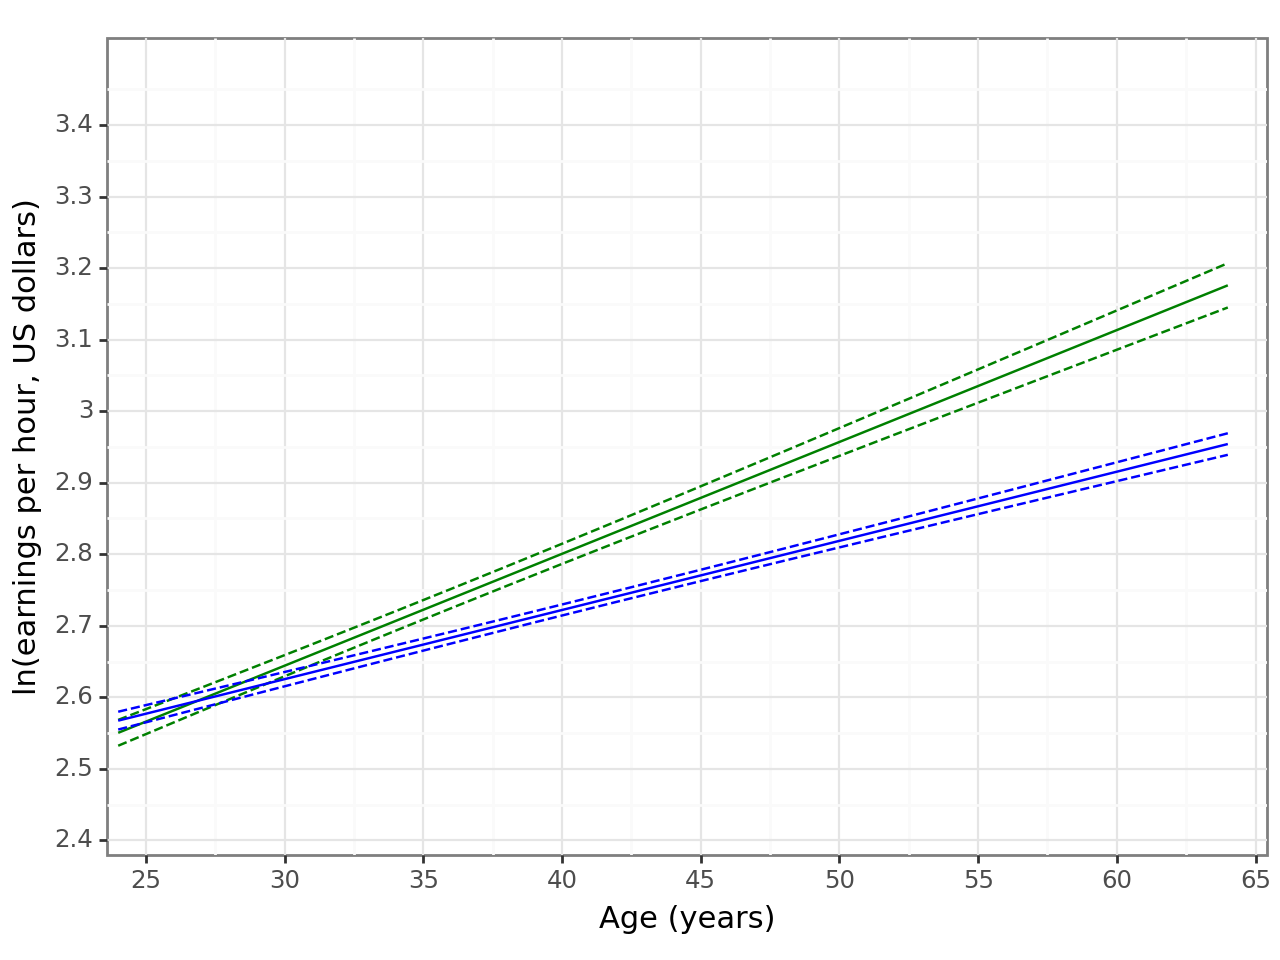

<Figure Size: (640 x 480)>

In [30]:
# visualizing
(
    ggplot(data_m, aes(x="age", y="fit"))
    + geom_line(colour='green')
    + geom_line(data_m, aes(x="age", y="CIup"), colour='green', linetype="dashed")
    + geom_line(data_m, aes(x="age", y="CIlo"), colour='green', linetype="dashed")
    + geom_line(data_f, aes(x="age", y="fit"), colour='blue')
    + geom_line(data_f, aes(x="age", y="CIup"), colour='blue', linetype="dashed")
    + geom_line(data_f, aes(x="age", y="CIlo"), colour='blue', linetype="dashed")
    + labs(x="Age (years)", y="ln(earnings per hour, US dollars)")
    + scale_x_continuous(expand=(0.01, 0.01), limits=(24, 65), breaks=np.arange(25, 66, 5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(2.4, 3.5), breaks = np.arange(2.4, 3.5, 0.1))
    + theme_bw()
)

Initially, female office specialists have higher earnings, but the rate of salary growth for males surpasses that of females, as revealed in our regression analysis.

The inclusion of the interaction term allows us to observe that the disparity in earnings becomes more pronounced as individuals get older. The wage gap widens over time.

# Gender differences in earnings – log earnings, gender, 2nd, 3rd and 4th-order polynomial of age, and their interaction

In [31]:
# adding square, cubes, quadratic
cps["agesq"] = np.power(cps["age"], 2)
cps["agecu"] = np.power(cps["age"], 3)
cps["agequ"] = np.power(cps["age"], 4)

In [32]:
reg10 = smf.ols(formula="lnw~age+agesq+agecu+agequ", data=cps.query("female==1")).fit(
    cov_type="HC1"
) #women
reg11 = smf.ols(formula="lnw~age+agesq+agecu+agequ", data=cps.query("female==0")).fit(
    cov_type="HC1"
) #men
reg12 = smf.ols(
    formula="lnw ~ age + agesq + agecu + agequ + female + female*age + female*agesq + female*agecu + female*agequ",
    data=cps,
).fit(cov_type="HC1")
 # interactions

In [33]:
Stargazer([reg10, reg11, reg12])

**interpretation**

(1) and (2) We can see that only age contribution is pretty big.
(3) Shows that gender and age matters the most, and being female affects salary negatively

## Visualizing the polynomial regression model

In [34]:
# PREDICTION AND GRAPH POLYNOMIAL
# male
data_m = cps.query("female==0")

pred = reg12.predict(data_m)

pred = reg12.get_prediction(data_m).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_m = data_m.reset_index(drop=True).join(pred)

data_m["CIup"] = data_m["fit"] + 2 * data_m["fit_se"]
data_m["CIlo"] = data_m["fit"] - 2 * data_m["fit_se"]

# female
data_f = cps.query("female==1")

pred = reg12.predict(data_f)

pred = reg12.get_prediction(data_f).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_f = data_f.reset_index(drop=True).join(pred)

data_f["CIup"] = data_f["fit"] + 2 * data_f["fit_se"]
data_f["CIlo"] = data_f["fit"] - 2 * data_f["fit_se"]

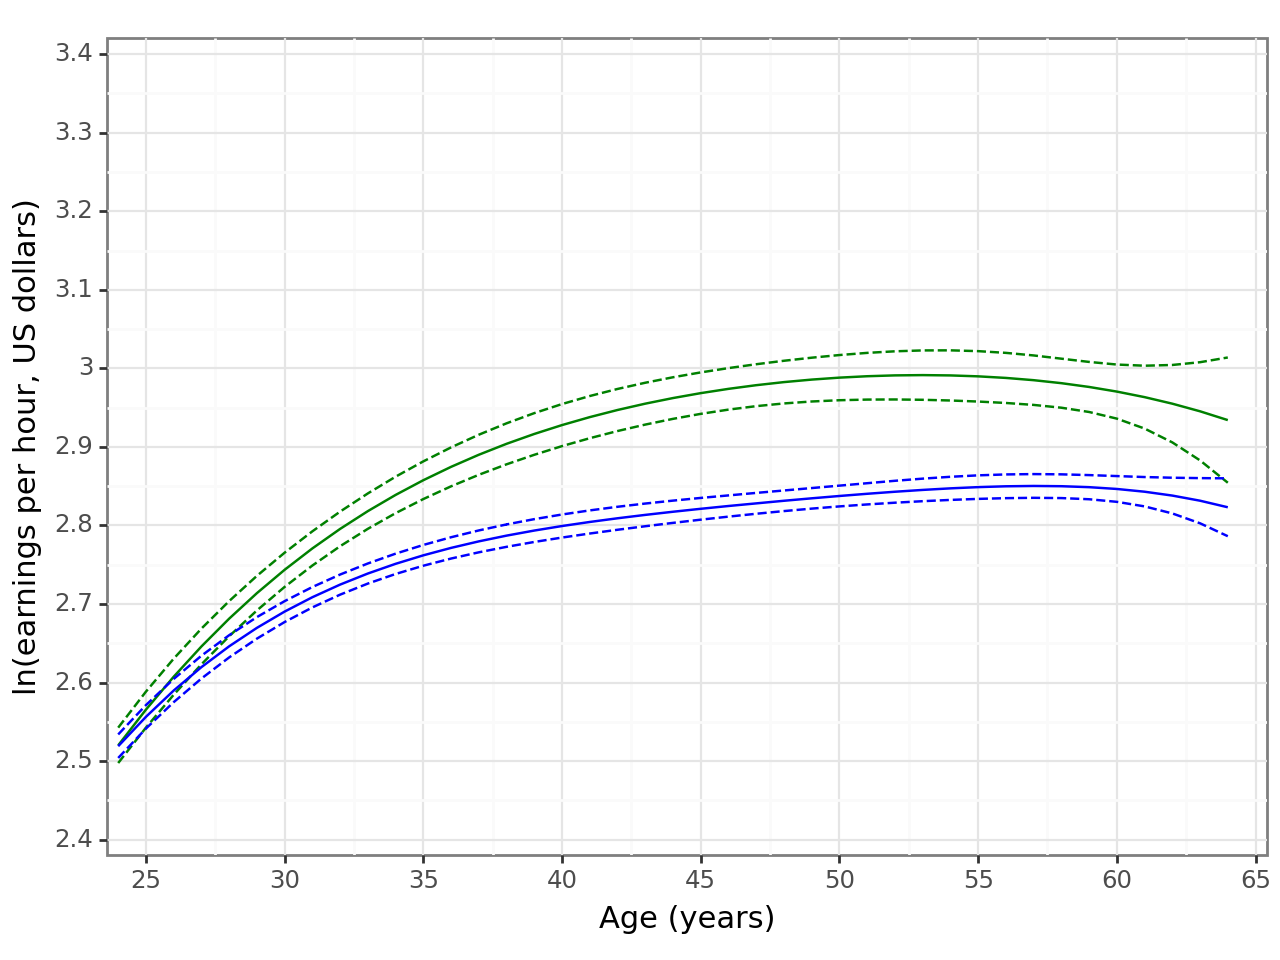

<Figure Size: (640 x 480)>

In [35]:
(
    ggplot(data_m, aes(x="age", y="fit"))
    + geom_line(colour='green')
    + geom_line(data_m, aes(x="age", y="CIup"), colour='green', linetype="dashed")
    + geom_line(data_m, aes(x="age", y="CIlo"), colour='green', linetype="dashed")
    + geom_line(data_f, aes(x="age", y="fit"), colour='blue')
    + geom_line(data_f, aes(x="age", y="CIup"), colour='blue', linetype="dashed")
    + geom_line(data_f, aes(x="age", y="CIlo"), colour='blue', linetype="dashed")
    + labs(x="Age (years)", y="ln(earnings per hour, US dollars)")
    + scale_x_continuous(expand=(0.01, 0.01), limits=(24, 65), breaks=np.arange(25, 66, 5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(2.4, 3.4), breaks=np.arange(2.4, 3.5,0.1)
    )
    + theme_bw()
)

**interpretation**
Initially, there is no observable difference visually.

For individuals up to the age of 30, the disparity is relatively minimal, but it starts expanding.

Around the age of 50, the wage gap between males and females is approximately 20%. 

Finally, the gap decreases, reaching around 15%.

The confidence intervals for the coefficients between men and women do not overlap and are narrow, except for the two ends.


## Towards causal analysis
IS IT DISCRIMINATION?

In the data we analyze relatively large and stable average gender difference in earnings.

Analyze it to see if members of a group (women, minorities) earn systematically less per hour than the others (men, majority), all other things being equal 

In [36]:
# adding races, being US citizen
cps["white"] = (cps["race"] == 1).astype(int)
cps["afram"] = (cps["race"] == 2).astype(int)
cps["asian"] = (cps["race"] == 4).astype(int)
cps["hisp"] = (cps["ethnic"].notna()).astype(int)
cps["othernonw"] = (
    (cps["white"] == 0) & (cps["afram"] == 0) & (cps["asian"] == 0) & (cps["hisp"] == 0)
).astype(int) #other nonwhite
cps["nonUSborn"] = (
    (cps["prcitshp"] == "Foreign Born, US Cit By Naturalization")
    | (cps["prcitshp"] == "Foreign Born, Not a US Citizen")
).astype(int)

In [37]:
# Potentially marital staus, having kids, work nature 
cps["married"] = ((cps["marital"] == 1) | (cps["marital"] == 2)).astype(int)
cps["divorced"] = ((cps["marital"] == 3) & (cps["marital"] == 5)).astype(int)
cps["wirowed"] = (cps["marital"] == 4).astype(int)
cps["nevermar"] = (cps["marital"] == 7).astype(int)

cps["child0"] = (cps["chldpres"] == 0).astype(int)
cps["child1"] = (cps["chldpres"] == 1).astype(int)
cps["child2"] = (cps["chldpres"] == 2).astype(int)
cps["child3"] = (cps["chldpres"] == 3).astype(int)
cps["child4pl"] = (cps["chldpres"] >= 4).astype(int)

# Work-related variables
cps["fedgov"] = (cps["class"] == "Government - Federal").astype(int)
cps["stagov"] = (cps["class"] == "Government - State").astype(int)
cps["locgov"] = (cps["class"] == "Government - Local").astype(int)
cps["nonprof"] = (cps["class"] == "Private, Nonprofit").astype(int)
cps["ind2dig"] = ((pd.Categorical(cps["ind02"]).codes + 1) / 100).astype(int)
cps["occ2dig"] = (cps["occ2012"] / 100).astype(int)
cps["union"] = ((cps["unionmme"] == "Yes") | (cps["unioncov"] == "Yes")).astype(int)

In [38]:
# adding square, cube and quartic
cps["uhourssq"] = np.power(cps["uhours"], 2)
cps["uhourscu"] = np.power(cps["uhours"], 3)
cps["uhoursqu"] = np.power(cps["uhours"], 4)

In [39]:
# Extended regressions
reg1 = smf.ols(formula="lnw ~ female", data=cps).fit(cov_type="HC1")
reg2 = smf.ols(formula="lnw ~ female + age + ed_Profess + ed_Phd", data=cps).fit(
    cov_type="HC1"
)
reg3 = smf.ols(
    formula="lnw ~ female + age + afram + hisp + asian + othernonw + nonUSborn + ed_Profess + ed_Phd + married + divorced+ wirowed + child1 + child2 + child3 +child4pl + C(stfips) + uhours + fedgov + stagov + locgov + nonprof + union + C(ind2dig) + C(occ2dig)",
    data=cps,
).fit(cov_type="HC1")
reg4 = smf.ols(
    formula="lnw ~ female + age + afram + hisp + asian + othernonw + nonUSborn + ed_Profess + ed_Phd + married + divorced+ wirowed + child1 + child2 + child3 +child4pl + C(stfips) + uhours + fedgov + stagov + locgov + nonprof + union + C(ind2dig) + C(occ2dig) + agesq + agecu + agequ + uhoursqu + uhourscu + uhourssq",
    data=cps,
).fit(cov_type="HC1")

In [40]:
# Extended regressions
reg1 = smf.ols(formula="lnw ~ female", data=cps).fit(cov_type="HC1")
reg2 = smf.ols(formula="lnw ~ female + age + ed_Profess + ed_Phd", data=cps).fit(
    cov_type="HC1"
)
reg3 = smf.ols(
    formula="lnw ~ female + age + afram + hisp + asian + othernonw + nonUSborn + ed_Profess + ed_Phd + married + divorced+ wirowed + child1 + child2 + child3 +child4pl + C(stfips) + uhours + fedgov + stagov + locgov + nonprof + union + C(ind2dig) + C(occ2dig)",
    data=cps,
).fit(cov_type="HC1")
reg4 = smf.ols(
    formula="lnw ~ female + age + afram + hisp + asian + othernonw + nonUSborn + ed_Profess + ed_Phd + married + divorced+ wirowed + child1 + child2 + child3 +child4pl + C(stfips) + uhours + fedgov + stagov + locgov + nonprof + union + C(ind2dig) + C(occ2dig) + agesq + agecu + agequ + uhoursqu + uhourscu + uhourssq",
    data=cps,
).fit(cov_type="HC1")
stargazer = Stargazer([reg1, reg2, reg3, reg4])
stargazer.covariate_order(["female"])
stargazer.add_line("Age and education", ["", "Yes", "Yes", "Yes"])
stargazer.add_line("Family circumstances", ["", "", "Yes", "Yes"])
stargazer.add_line("Demographic background", ["", "", "Yes", "Yes"])
stargazer.add_line("Job characteristics", ["", "", "Yes", "Yes"])
stargazer.add_line("Age in polynomial", ["", "", "", "Yes"])
stargazer.add_line("Hours in polynomial", ["", "", "", "Yes"])
stargazer

(1) Interpretation: On average, being female is associated with a 3.2% less of hourly wages.

(2) With the inclusion of age and education covariates, the estimated effect of being female on hourly wages increases to -0.077 or around -8 percent.

(3) After accounting for family circumstances, demographic background, and job characteristics, the effect of being female on hourly wages is estimated to be -7.4%

(4) With the inclusion of age and hours in polynomial terms, the estimated effect of being female remains at -7.7%.

In summary, the models suggest that being female is associated with a statistically significant decrease in hourly wages, even after accounting for various covariates. The models' explanatory power improves with the inclusion of additional covariates, as indicated by the increase in R-squared values.